<a href="https://colab.research.google.com/github/jinwoo3239/DeepLearning_study/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Reference](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko) Tenssorflow tutorial

# Transfer learning

## Tensorflow
- tensorflow

### module

In [9]:
import os
import cv2
import PIL

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-08-20 12:04:20--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   262MB/s    in 0.3s    

2022-08-20 12:04:21 (262 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [6]:
!unzip -q 'cats_and_dogs_filtered.zip'

In [7]:
source_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

train_dir = os.path.join(source_dir, 'train')
val_dir = os.path.join(source_dir, 'validation')

batch_size = 32
img_size = (160, 160)

In [8]:
train_dataset = image_dataset_from_directory(directory=train_dir,
                                             batch_size=32,
                                             shuffle=True,
                                             image_size=img_size,
                                             seed=1)

Found 2000 files belonging to 2 classes.


In [10]:
val_dataset = image_dataset_from_directory(directory=val_dir,
                                          batch_size=32,
                                           shuffle=True,
                                          image_size=img_size)

Found 1000 files belonging to 2 classes.


In [11]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

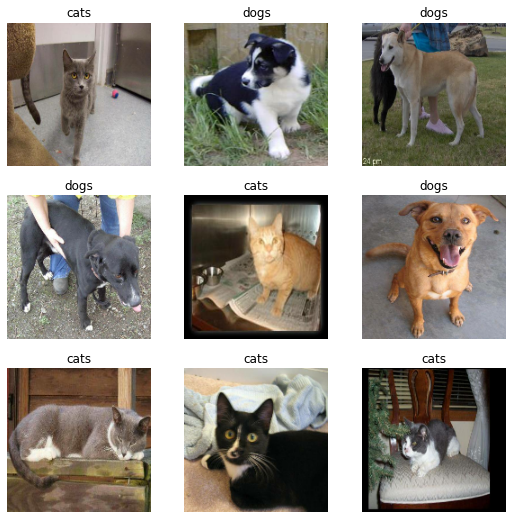

In [13]:
samples = next(iter(train_dataset))

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(samples[0][i].numpy().astype('int'))
    plt.title(class_names[samples[1][i]])
    plt.axis('off')


In [14]:
## identification of numbers of batches

val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
val_datches = val_dataset.skip(val_batches//5)

In [ ]:
# Enhancing the performence by using prefetch
# https://www.tensorflow.org/guide/data_performance?hl=ko

# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
# data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', seed=1),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

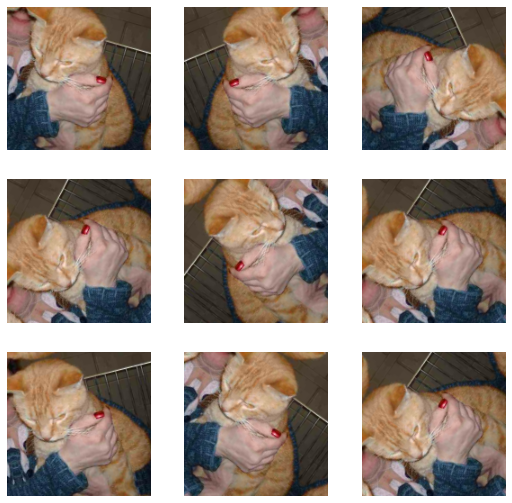

In [21]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(9, 9))
    first_img = image[0]
    for i in range(9):
        plt.subplot(3, 3, i+1)
        augmented_img = data_augmentation(tf.expand_dims(first_img, axis=0))[0]
        plt.imshow(augmented_img.numpy()/255. )
        plt.axis('off')
plt.show();

In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', seed=1),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_size + (3,)),
                                                            include_top=False,
                                                            weights='imagenet')

base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

In [30]:
IMG_SIZE = img_size + (3, )

inputs = tf.keras.Input(shape=(IMG_SIZE))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

In [31]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [32]:
history = model.fit(train_dataset, epochs=5, callbacks=callbacks, validation_data=val_dataset)

Epoch 1/5
63/63 [==============================] - 19s 81ms/step - loss: 0.3467 - accuracy: 0.8305 - val_loss: 0.1065 - val_accuracy: 0.9680
Epoch 2/5
63/63 [==============================] - 4s 62ms/step - loss: 0.1717 - accuracy: 0.9275 - val_loss: 0.0724 - val_accuracy: 0.9730
Epoch 3/5
63/63 [==============================] - 4s 61ms/step - loss: 0.1479 - accuracy: 0.9340 - val_loss: 0.0640 - val_accuracy: 0.9800
Epoch 4/5
63/63 [==============================] - 4s 63ms/step - loss: 0.1368 - accuracy: 0.9450 - val_loss: 0.0576 - val_accuracy: 0.9780
Epoch 5/5
63/63 [==============================] - 4s 64ms/step - loss: 0.1267 - accuracy: 0.9460 - val_loss: 0.0737 - val_accuracy: 0.9620


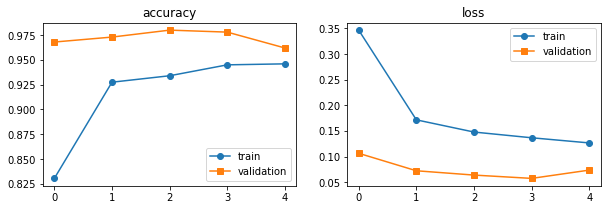

In [39]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['accuracy'], label='train', marker='o')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation', marker='s')
plt.title('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['loss'], label='train', marker='o')
plt.plot(history.epoch, history.history['val_loss'], label='validation', marker='s')
plt.title('loss')
plt.legend()

plt.show();

In [40]:
model.evaluate(test_dataset)

6/6 [==============================] - 1s 53ms/step - loss: 0.1006 - accuracy: 0.9479


[0.10063939541578293, 0.9479166865348816]

In [45]:
class mymodel(tf.keras.Model):

    def __init__(self, training=False):
        super(mymodel, self).__init__()
        self.preprocess_inputs = tf.keras.applications.mobilenet_v2.preprocess_input
        self.base_models = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(160, 160, 3), include_top=False)
        self.globalaverage = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense = tf.keras.layers.Dense(1)

        self.base_models.trainable=False

        if training:
            self.base_models.trainable=True

    def call(self, x):
        x = self.preprocess_inputs(x)
        x = self.base_models(x)
        x = self.globalaverage(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x

In [54]:
model2 = mymodel(training=False)

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

model2.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
model2.evaluate(test_dataset)

6/6 [==============================] - 2s 50ms/step - loss: 0.7638 - accuracy: 0.5208


[0.7638399004936218, 0.5208333134651184]

In [55]:
model2.fit(train_dataset, epochs=5, callbacks=callbacks, validation_data=val_dataset)

Epoch 1/5
63/63 [==============================] - 6s 62ms/step - loss: 0.2131 - accuracy: 0.9010 - val_loss: 0.0830 - val_accuracy: 0.9730
Epoch 2/5
63/63 [==============================] - 4s 68ms/step - loss: 0.0721 - accuracy: 0.9750 - val_loss: 0.0578 - val_accuracy: 0.9800
Epoch 3/5
63/63 [==============================] - 4s 61ms/step - loss: 0.0529 - accuracy: 0.9815 - val_loss: 0.0506 - val_accuracy: 0.9800
Epoch 4/5
63/63 [==============================] - 4s 61ms/step - loss: 0.0423 - accuracy: 0.9870 - val_loss: 0.0451 - val_accuracy: 0.9840
Epoch 5/5
63/63 [==============================] - 4s 61ms/step - loss: 0.0359 - accuracy: 0.9860 - val_loss: 0.0437 - val_accuracy: 0.9840


In [56]:
model2.evaluate(test_dataset)

6/6 [==============================] - 1s 74ms/step - loss: 0.0683 - accuracy: 0.9740


[0.06834578514099121, 0.9739583134651184]